In [43]:
previous="mit"
original="ptdb"
combine=previous+"_"+original

data_path=combine

In [44]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import shutil
import torch
from torch import nn
import torch.utils.data
import torch.optim as optim
import random
import time

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()


root_path="../input/ecgdatasets/classification/"+data_path
cuda=torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
    
class opt:
    batch_size=64
    workers=2
    lr=0.001
    train_path=root_path+"/train.csv"
    test_path=root_path+"/test.csv"
    
#change this
from models import LSTMClassifier
from models import loss_function_c as loss_function
network=LSTMClassifier().to(device)
network.load_state_dict(torch.load("../models/classifier_"+data_path+".pt",map_location="cpu"))   

torch.Size([64, 187]) torch.float64
torch.Size([64]) torch.float64


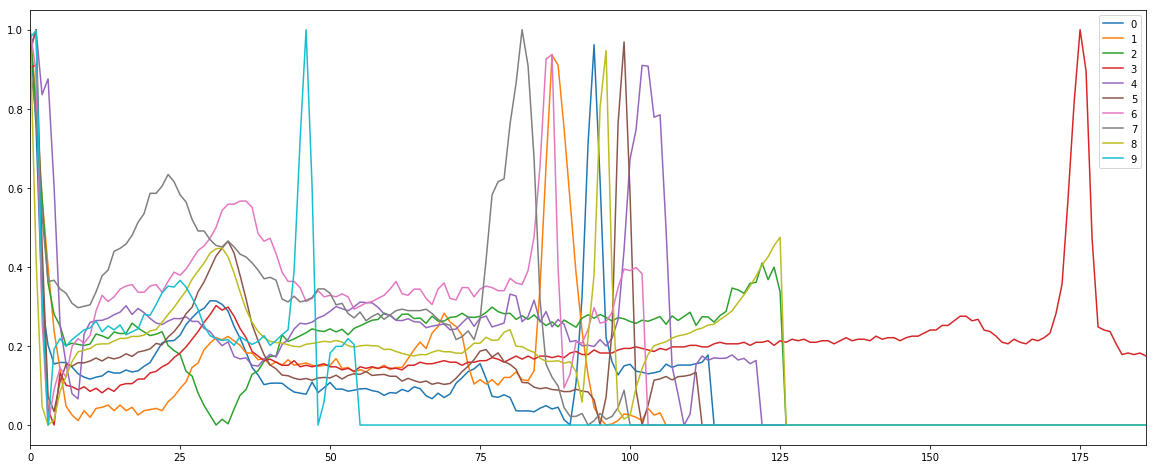

In [45]:
class ECGDataset(torch.utils.data.Dataset):
    
    def __init__(self,path):
        self.data=pd.read_csv(path,header=None)
        
    def __getitem__(self,idx):
        x=self.data.loc[idx,:186].values # removed the label
        y=self.data.loc[idx,187]
        return x,y
    
    def __len__(self):
        return len(self.data)
        

train_dsest=ECGDataset(opt.test_path)
trainloader=torch.utils.data.DataLoader(train_dsest,
                                       batch_size=opt.batch_size,
                                       shuffle=True,
                                        num_workers=opt.workers)

for x,y in trainloader:
    print(x.shape,x.dtype)
    print(y.shape,y.dtype)
    
    x=x.numpy()
    x=pd.DataFrame(x)
    x.iloc[:10,:].T.plot(figsize=(20,8))
    plt.show() #plot to check the data pipeline is working well
    break

In [46]:
class ECGTestDataset(torch.utils.data.Dataset):
    
    def __init__(self,path):
        self.data=pd.read_csv(path)
        
    def __getitem__(self,idx):
        x=self.data.iloc[idx,:186].values # removed the label
        y=self.data.iloc[idx,187]
        return x,y
    
    def __len__(self):
        return len(self.data)
        
    
test_dset=ECGTestDataset(opt.test_path)
testloader=torch.utils.data.DataLoader(test_dset,
                                       batch_size=1,
                                       shuffle=True,
                                        num_workers=opt.workers)

In [47]:
def get_prediction(loader):
    network.eval()
    normal_pred=[]
    patient_pred=[]
    for i,(signal,label) in enumerate(loader):
        signal=signal.to(device).float()#batch_size,187
        label=label.to(device).int()
        network.zero_grad()
        output=network(signal).item()
        if(label==1):
            if(output>0.5):
                patient_pred.append(1)
            else:
                patient_pred.append(0)
        else:
            if(output>0.5):
                normal_pred.append(1)
            else:
                normal_pred.append(0)
            
        

    return np.array(patient_pred),np.array(normal_pred)

### returns the predictions
    
patient_pred,normal_pred=get_prediction(testloader)

In [48]:
def print_metrics(patient_pred,normal_pred,beta):

    normal_true=np.zeros_like(normal_pred)
    patient_true=np.ones_like(patient_pred)

    tp=sum(patient_pred)
    fp=sum(normal_pred)
    tn=len(normal_pred)-fp
    fn=len(patient_pred)-tp
    
    
    accuracy_normal=tn/len(normal_pred)
    accuracy_patient=tp/len(patient_pred)
    accuracy_total=(tp+tn)/(len(normal_pred)+len(patient_pred))

    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    num=(1+beta**2)*(precision*recall)
    den=((beta**2)*precision)+recall
    fscore=num/den

    print(f"Beta : {beta}")
    print(f"Accuracy Normal: {accuracy_normal*100:.2f}%")
    print(f"Accuracy Patient: {accuracy_patient*100:.2f}%")
    print(f"Accuracy Total: {accuracy_total*100:.2f}%")

    print(f"Precision : {precision:.3f}")
    print(f"Recall : {recall:.3f}")
    print(f"Fscore : {fscore:.3f}")
    print("\n")
    
    
print_metrics(patient_pred,normal_pred,1)
print_metrics(patient_pred,normal_pred,5)

Beta : 1
Accuracy Normal: 58.49%
Accuracy Patient: 92.55%
Accuracy Total: 74.50%
Precision : 0.664
Recall : 0.926
Fscore : 0.773


Beta : 5
Accuracy Normal: 58.49%
Accuracy Patient: 92.55%
Accuracy Total: 74.50%
Precision : 0.664
Recall : 0.926
Fscore : 0.912


